In [1]:
!pip install "protobuf<4.0.0" --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
a2a-sdk 0.3.22 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.1 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3

In [2]:
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.


In [3]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.1
    Uninstalling sentence-transformers-5.1.1:
      Successfully uninstalled sentence-transformers-5.1.1


In [4]:
import transformers

print("Transformers:", transformers.__version__)
# print("Sentence Transformers:", sentence_transformers.__version__)


Transformers: 4.57.1


In [5]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [6]:
import random, os
import numpy as np
import torch


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [7]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT_Description', 'BERT4News_Description', 'ViBERT_Description']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.desc_size = 768
        
        if 'PhoBERT' in model_name:
            self.bert = AutoModel.from_pretrained('ngcanh/sentiment-spam-phobert')
        else:
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size + self.desc_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask, description):
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        conc = torch.cat((output, description), 1)
        x = self.drop(conc)
        x = self.fc(x)
        return x
    

2026-01-19 04:40:16.039359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768797616.233130      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768797616.290666      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768797616.748499      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768797616.748535      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768797616.748538      24 computation_placer.cc:177] computation placer alr

In [8]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'
# data_dir = '/kaggle/input/processed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [9]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [10]:
import sys
import os
from datetime import datetime

# ==================== DUAL LOGGER - VỪA IN MÀN HÌNH VỪA LƯU FILE ====================

class DualLogger:
    """
    Tự động COPY tất cả output:
    - Hiển thị trên màn hình như bình thường
    - ĐỒng thời lưu vào file
    
    Hoạt động với: print(), tqdm, warnings, errors, traceback...
    """
    def __init__(self, log_file):
        self.terminal = sys.stdout  # Giữ lại stdout gốc để in ra màn hình
        self.log = open(log_file, 'w', encoding='utf-8')
        
        # In thông báo bắt đầu logging
        start_msg = f"\n{'='*80}\nLOGGING STARTED\nFile: {log_file}\nTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n{'='*80}\n"
        self.terminal.write(start_msg)
        self.log.write(start_msg)
        self.log.flush()
        
    def write(self, message):
        """Ghi message vào CẢ màn hình VÀ file"""
        self.terminal.write(message)  # ← In ra màn hình
        self.log.write(message)        # ← Lưu vào file
        self.log.flush()               # ← Đảm bảo ghi ngay không bị delay
        
    def flush(self):
        """Flush cả 2 streams"""
        self.terminal.flush()
        self.log.flush()
        
    def close(self):
        """Đóng file và restore stdout"""
        end_msg = f"\n{'='*80}\nLOGGING ENDED\nTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n{'='*80}\n"
        self.terminal.write(end_msg)
        self.log.write(end_msg)
        
        self.log.close()
        sys.stdout = self.terminal  # Restore lại stdout gốc


# ==================== CÁCH SỬ DỤNG ĐƠN GIẢN ====================

# Tạo thư mục logs
os.makedirs('logs', exist_ok=True)

# Tạo file log với timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = f'logs/full_training_log_{timestamp}.log'

# BẬT LOGGING - Từ đây mọi print() sẽ vừa hiện màn hình vừa lưu file
dual_logger = DualLogger(log_file)
sys.stdout = dual_logger


LOGGING STARTED
File: logs/full_training_log_20260119_044035.log
Time: 2026-01-19 04:40:35


In [11]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot


def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []

    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]

        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            description = data[f'encoded_description_{task}'].to(device)
            labels = data[label_column].to(device)
            
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())
            
    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    if len(history['train_loss']) <= 1:
        return False
    
    colors = plt.get_cmap('tab10').colors
    
    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)
    
    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))
    
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)
    
    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    

def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    elif  task == 2:
        labels = ['spam-1', 'spam-2', 'spam-3']
        font_size = 22
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [14]:
import torch
from tqdm import tqdm
import numpy as np

def test_pipeline(model_task1, model_task2, dataloader, device):
    model_task1.eval()
    model_task2.eval()
    
    all_predicts = []
    all_true_labels = []
    
    # We use 'spam_label' (0, 1, 2, 3) as the ground truth for the final evaluation
    label_column = 'spam_label' 

    print("Running Pipeline Testing...")
    for data in tqdm(dataloader):
        # 1. Prepare Base Inputs
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)
        
        # 2. Prepare Task-Specific Descriptions
        # Task 1 needs description 1, Task 2 needs description 2
        desc_task1 = data['encoded_description_1'].to(device)
        desc_task2 = data['encoded_description_2'].to(device)

        with torch.no_grad():
            # -----------------------------
            # STEP A: Run Task 1 (Spam Detection)
            # -----------------------------
            outputs1 = model_task1(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                description=desc_task1
            )
            # 0=Non-Spam, 1=Spam (Binary)
            pred1_indices = torch.max(outputs1, dim=1)[1]
            
            # Start final predictions with Task 1 results.
            # Currently: 0 or 1.
            final_batch_preds = pred1_indices.clone()

            # -----------------------------
            # STEP B: Run Task 2 (Spam Type)
            # -----------------------------
            # Find indices where Task 1 predicted "Spam" (1)
            # These are the only ones we send to Model 2
            spam_mask = (pred1_indices == 1)
            spam_indices = torch.nonzero(spam_mask).squeeze()

            if spam_indices.numel() > 0:
                # Handle edge case: if only 1 item is spam, squeeze() makes it 0-d
                if spam_indices.dim() == 0:
                    spam_indices = spam_indices.unsqueeze(0)
                
                # Filter inputs for just the spam items
                sub_input_ids = input_ids[spam_indices]
                sub_attention_mask = attention_mask[spam_indices]
                sub_desc_task2 = desc_task2[spam_indices] # Use Desc 2 here
                
                # Run Model 2
                outputs2 = model_task2(
                    input_ids=sub_input_ids, 
                    attention_mask=sub_attention_mask, 
                    description=sub_desc_task2
                )
                
                # Model 2 predicts 0, 1, 2.
                pred2_indices = torch.max(outputs2, dim=1)[1]
                
            
                
                # Update the final predictions tensor
                # We place the refined labels back into the positions defined by the mask
                final_batch_preds[spam_mask] = pred2_indices
            
            # Store results
            all_predicts.extend(final_batch_preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return all_true_labels, all_predicts

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_pipeline(true_labels, predicts):
    # Calculate Metrics
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    # Print Results
    print("--- Pipeline Combined Results ---")
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    
    # Check if we have labels 0, 1, 2, 3 in the result to verify target names match
    # Usually: 0=Safe, 1=Type1, 2=Type2, 3=Type3
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_learning_curve(history, task_name="Task"):
    """
    Plots the Training vs Validation Learning Curve.
    
    Args:
        history (dict): Dictionary containing 'train_loss', 'val_loss', 
                        'train_acc', and 'val_acc'.
        task_name (str): Title prefix (e.g., "Task 1 - Spam Detection")
    """
    # Use a clean style
    sns.set(style='whitegrid')
    
    # Create a figure with 2 subplots (Loss and Accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # --- Plot 1: Loss ---
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
    ax1.set_title(f'{task_name}: Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=12)
    
    # --- Plot 2: Accuracy ---
    if 'train_acc' in history and 'val_acc' in history:
        ax2.plot(epochs, history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
        ax2.plot(epochs, history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2)
        ax2.set_title(f'{task_name}: Accuracy', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Accuracy', fontsize=14)
        ax2.legend(fontsize=12)
        
        # Set y-axis to always show 0-1 range if it's accuracy
        # ax2.set_ylim([0, 1.05]) 
    else:
        ax2.text(0.5, 0.5, 'Accuracy not found in history', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

# PhoBERT

In [17]:
import torch
from transformers import AutoTokenizer, AutoModel

# 1. Tải Tokenizer và Model (PhoBERT cần Model để tạo embedding)
tokenizer = AutoTokenizer.from_pretrained("ngcanh/sentiment-spam-phobert")
model = AutoModel.from_pretrained("ngcanh/sentiment-spam-phobert").to("cuda") # Chuyển lên GPU

def encode_description(batch):
    texts = batch["clean_description"]
    # Xử lý dữ liệu trống
    texts = [str(t) if t is not None else "" for t in texts]

    # 2. Tokenize toàn bộ batch
    inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=256, 
        return_tensors='pt'
    ).to("cuda")

    # 3. Chạy qua Model để lấy hidden states
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Mean Pooling: Tính trung bình cộng các token để ra vector đại diện cho câu
    # Lấy layer cuối cùng (last_hidden_state)
    token_embeddings = outputs.last_hidden_state
    mask = inputs['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
    
    sum_embeddings = torch.sum(token_embeddings * mask, 1)
    sum_mask = torch.clamp(mask.sum(1), min=1e-9)
    
    # Kết quả là vector embedding (thường có kích thước 768)
    embeddings = (sum_embeddings / sum_mask).cpu().numpy()

    # Trả về kết quả dưới dạng list để map vào dataset
    return {
        "encoded_description_1": embeddings.tolist(),
        "encoded_description_2": embeddings.tolist()
    }

# 5. Chạy Map với batch_size phù hợp
vispam_datasets = vispam_datasets.map(
    encode_description,
    batched=True,
    batch_size=32 # Giảm xuống 32 để tránh lỗi CUDA out of memory trên Kaggle
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Map:   0%|          | 0/14284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

Map:   0%|          | 0/3963 [00:00<?, ? examples/s]

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ngcanh/sentiment-spam-phobert")

def encode_comment(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_comment, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")


Map:   0%|          | 0/14284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

Map:   0%|          | 0/3963 [00:00<?, ? examples/s]

In [19]:
from torch.utils.data import DataLoader

def filter_spam_only(example):
    return example['spam_label'] != 0

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)

train_dataloader_2 = DataLoader(encoded_datasets['train'].filter(filter_spam_only), shuffle=True, batch_size=16)
val_dataloader_2 = DataLoader(encoded_datasets['dev'].filter(filter_spam_only), batch_size=16)
test_dataloader_2 = DataLoader(encoded_datasets['test'].filter(filter_spam_only), batch_size=16)





Filter:   0%|          | 0/14284 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1589 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3963 [00:00<?, ? examples/s]

## Task 1

In [20]:
from torch import nn
import torch.optim as optim  # Sử dụng thư viện tối ưu của PyTorch
from transformers import get_linear_schedule_with_warmup

model = ViSpam_Classifier(model_name="PhoBERT_Description", task=1).to(device)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-5
) 

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(train_dataloader) * epochs
)

early_stopping = EarlyStopping(patience=3, delta=0)

history_task1 = train(
    model, 
    criterion, 
    optimizer, 
    train_dataloader, 
    val_dataloader, 
    epochs, 
    early_stopping, 
    task=1
)

100%|██████████| 893/893 [02:34<00:00,  5.78it/s]


In [21]:
save_visualization_history(history_task1, 'PhoBERT_Description', task=1)
plotting_history(history_task1)


In [22]:
import os
import torch

model_name = "PhoBERT_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts_1 = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts_1)


100%|██████████| 248/248 [00:12<00:00, 20.58it/s]


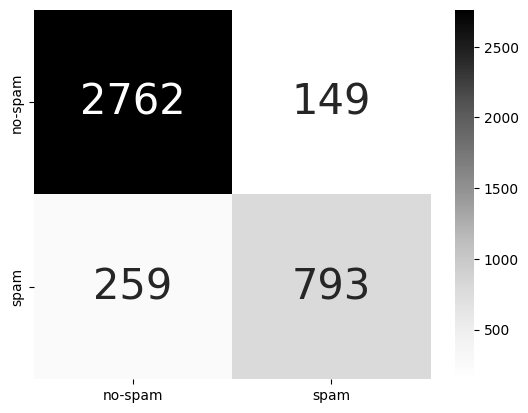

In [23]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [24]:
from torch import nn
import torch.optim as optim  # Sử dụng thư viện tối ưu của PyTorch
from transformers import get_linear_schedule_with_warmup

model = ViSpam_Classifier(model_name="PhoBERT_Description", task=2).to(device)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-5
) 
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history_task2 = train(model, criterion, optimizer, train_dataloader_2, val_dataloader_2, epochs, early_stopping, task=2)


100%|██████████| 237/237 [00:41<00:00,  5.78it/s]


In [25]:
save_visualization_history(history_task2, 'PhoBERT_Description', task=2)
plotting_history(history_task2)


In [26]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

model_name = "PhoBERT_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))

spam_indices = [i for i, pred in enumerate(predicts_1) if pred == 1]

spam_subset = Subset(test_dataloader_2.dataset, spam_indices)

task2_test_dataloader = DataLoader(
        spam_subset,
        batch_size=test_dataloader.batch_size,
        shuffle=False, # Keep False for testing
        num_workers=test_dataloader.num_workers,
)

true_labels, predicts = test(model, test_dataloader_2, task=2)
test_cm = evaluate(true_labels, predicts)


100%|██████████| 66/66 [00:03<00:00, 20.60it/s]


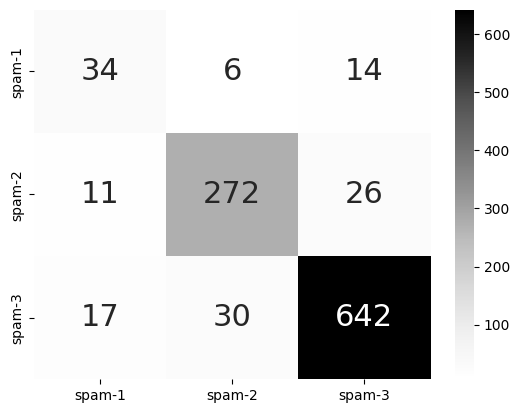

In [27]:
plotting_confusion_matrix(test_cm, task=2)


## Combine

In [28]:
path_to_model2 = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
path_to_model1 = os.path.join(model_name, f"{model_name}_last_model_(1).pth")


model1 = ViSpam_Classifier(model_name, task=1).to(device)
model1.load_state_dict(torch.load(path_to_model1))

model2 = ViSpam_Classifier(model_name, task=2).to(device)
model2.load_state_dict(torch.load(path_to_model2))

true_labels, pipeline_preds = test_pipeline(model1, model2, test_dataloader, device)

cm = evaluate_pipeline(true_labels, pipeline_preds)

100%|██████████| 248/248 [00:15<00:00, 15.61it/s]


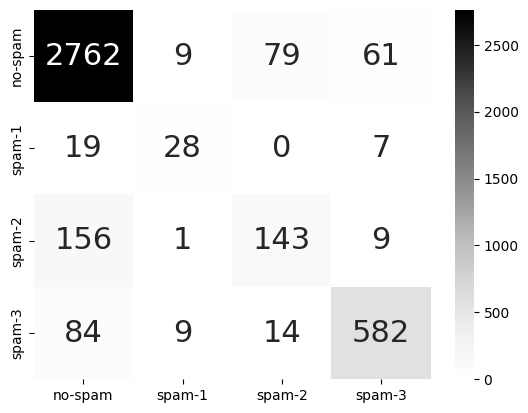

In [29]:
plotting_confusion_matrix(cm, task=3)


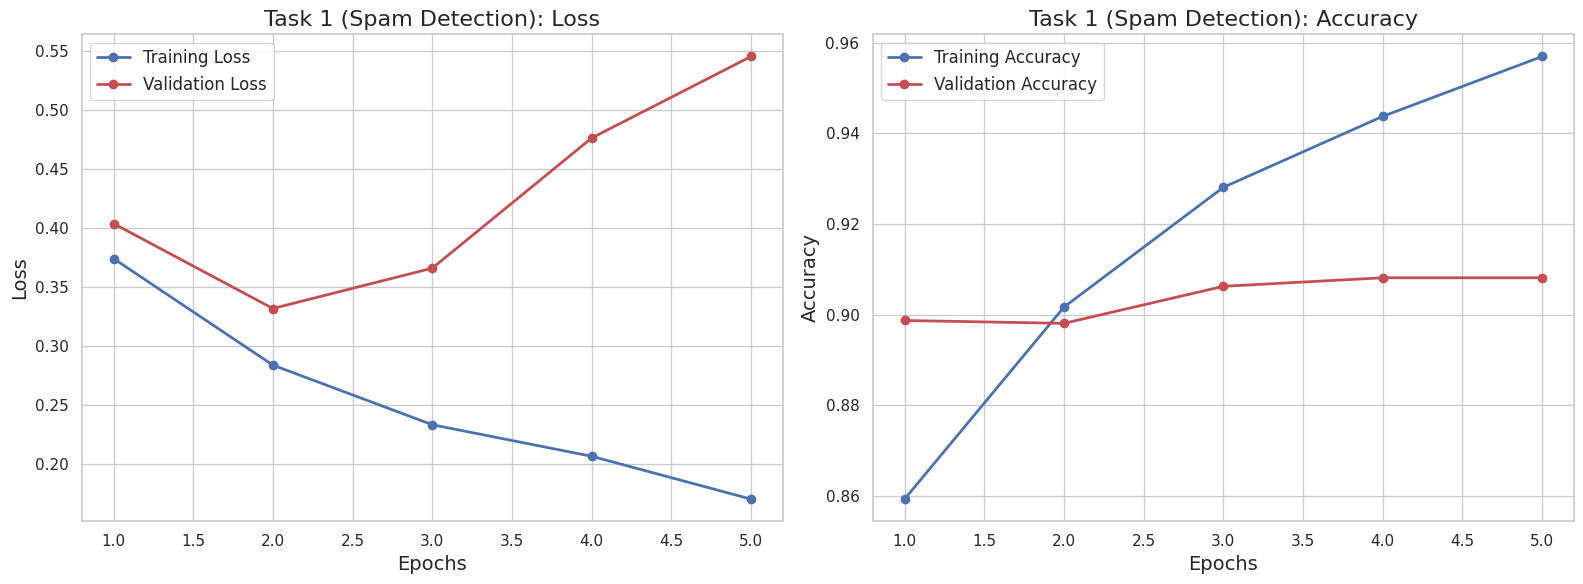

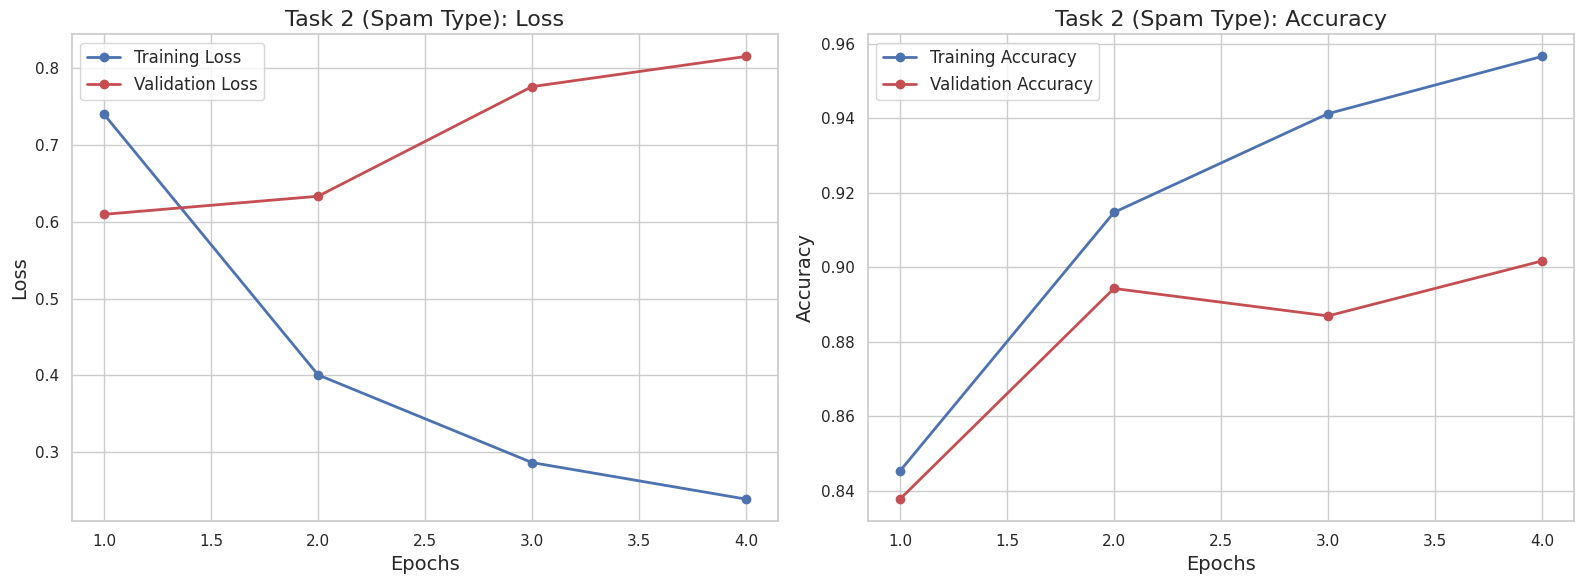

In [30]:
# Assuming 'history_task1' is the return value from training Task 1
plot_learning_curve(history_task1, task_name="Task 1 (Spam Detection)")

# Assuming 'history_task2' is the return value from training Task 2
plot_learning_curve(history_task2, task_name="Task 2 (Spam Type)")

In [31]:
import pandas as pd
from tqdm import tqdm

def analyze_misclassifications(model, dataloader, task, dataset_split='test'):
    model.eval()
    misclassified_samples = []
    label_column = 'label' if task == 1 else 'spam_label'
    
    # Mapping nhãn
    if task == 1:
        label_map = {0: 'No-Spam', 1: 'Spam'}
    else:
        # Task 2: Xử lý cả ground truth (1,2,3) và prediction (0,1,2)
        label_map = {}
        for i in range(10):  # Tạo đủ mapping
            label_map[i] = f'Spam-{i}' if i > 0 else 'Spam-1'
    
    print(f"Đang phân tích lỗi dự đoán cho Task {task}...")
    
    batch_idx = 0
    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            pred = torch.max(outputs, dim=1)[1]
        
        incorrect_mask = (pred != labels)
        incorrect_indices = torch.nonzero(incorrect_mask).squeeze()
        
        if incorrect_indices.numel() > 0:
            if incorrect_indices.dim() == 0:
                incorrect_indices = incorrect_indices.unsqueeze(0)
            
            for idx in incorrect_indices:
                idx = idx.item()
                global_idx = batch_idx * dataloader.batch_size + idx
                
                # Lấy từ filtered dataset nếu là Subset
                try:
                    if hasattr(dataloader.dataset, 'indices'):
                        original_idx = dataloader.dataset.indices[global_idx]
                        original_comment = vispam_datasets[dataset_split][original_idx]['clean_tokenized_comment']
                    else:
                        original_comment = vispam_datasets[dataset_split][global_idx]['clean_tokenized_comment']
                except:
                    original_comment = "N/A"
                
                true_label = labels[idx].item()
                pred_label = pred[idx].item()
                
                misclassified_samples.append({
                    'Index': global_idx,
                    'Comment': original_comment,
                    'True_Label': f'Spam-{true_label}' if task == 2 else label_map.get(true_label, str(true_label)),
                    'Predicted_Label': f'Spam-{pred_label+1}' if task == 2 else label_map.get(pred_label, str(pred_label)),
                    'True_Label_Code': true_label,
                    'Predicted_Label_Code': pred_label
                })
        
        batch_idx += 1
    
    df_errors = pd.DataFrame(misclassified_samples)
    
    print(f"\n{'='*80}")
    print(f"TỔNG KẾT - TASK {task}")
    print(f"{'='*80}")
    print(f"Số mẫu lỗi: {len(df_errors)}")
    
    if len(df_errors) > 0:
        print(f"\nPhân bố lỗi:")
        print(df_errors['True_Label'].value_counts())
    
    return df_errors

In [32]:
def print_misclassified_samples(df_errors, max_display=20):
    """
    In ra chi tiết các mẫu bị dự đoán sai
    
    Args:
        df_errors: DataFrame từ hàm analyze_misclassifications
        max_display: Số lượng mẫu tối đa hiển thị (None = hiển thị tất cả)
    """
    if len(df_errors) == 0:
        print("Không có mẫu nào bị dự đoán sai!")
        return
    
    display_count = len(df_errors) if max_display is None else min(max_display, len(df_errors))
    
    print(f"\n{'='*80}")
    print(f"CHI TIẾT CÁC MẪU BỊ DỰ ĐOÁN SAI (Hiển thị {display_count}/{len(df_errors)} mẫu)")
    print(f"{'='*80}\n")
    
    for i, row in df_errors.head(display_count).iterrows():
        print(f"[{i+1}] Index: {row['Index']}")
        print(f"Comment: {row['Comment'][:200]}..." if len(row['Comment']) > 200 else f"Comment: {row['Comment']}")
        print(f"Nhãn thực tế: {row['True_Label']} ({row['True_Label_Code']})")
        print(f"Nhãn dự đoán: {row['Predicted_Label']} ({row['Predicted_Label_Code']})")
        print("-" * 80)
    
    if len(df_errors) > display_count:
        print(f"\n... và {len(df_errors) - display_count} mẫu khác")

In [33]:
def save_errors_to_csv(df_errors, filename):
    """
    Lưu danh sách lỗi ra file CSV
    
    Args:
        df_errors: DataFrame chứa các mẫu bị dự đoán sai
        filename: Tên file CSV để lưu
    """
    # Tạo thư mục nếu chưa có
    output_dir = os.path.dirname(filename)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Lưu ra CSV
    df_errors.to_csv(filename, index=False, encoding='utf-8-sig')
    
    print(f"\n{'='*80}")
    print(f"✓ Đã lưu {len(df_errors)} mẫu bị dự đoán sai vào file:")
    print(f"  {filename}")
    print(f"{'='*80}\n")

In [34]:
# TASK 1: Phân tích lỗi
print("\n" + "="*80)
print("PHÂN TÍCH LỖI DỰ ĐOÁN - TASK 1 (SPAM DETECTION)")
print("="*80)

# Load model Task 1
model_name = "PhoBERT_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model_task1 = ViSpam_Classifier(model_name, task=1).to(device)
model_task1.load_state_dict(torch.load(model_path))

# Phân tích lỗi Task 1
df_errors_task1 = analyze_misclassifications(model_task1, test_dataloader, task=1, dataset_split='test')

# In ra chi tiết
print_misclassified_samples(df_errors_task1, max_display=20)

# Lưu file
save_errors_to_csv(df_errors_task1, 'task1_misclassified_samples.csv')

100%|██████████| 248/248 [00:12<00:00, 19.94it/s]


In [35]:
# TASK 2: Phân tích lỗi
print("\n\n" + "="*80)
print("PHÂN TÍCH LỖI DỰ ĐOÁN - TASK 2 (SPAM TYPE CLASSIFICATION)")
print("="*80)

# Load model Task 2
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model_task2 = ViSpam_Classifier(model_name, task=2).to(device)
model_task2.load_state_dict(torch.load(model_path))

# Phân tích lỗi Task 2
df_errors_task2 = analyze_misclassifications(model_task2, test_dataloader_2, task=2, dataset_split='test')

# In ra chi tiết
print_misclassified_samples(df_errors_task2, max_display=20)

# Lưu file
save_errors_to_csv(df_errors_task2, 'task2_misclassified_samples.csv')

100%|██████████| 66/66 [00:03<00:00, 19.86it/s]
